Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [x] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [x] Begin with baselines for classification.
- [x] Use scikit-learn for logistic regression.
- [x] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [x] Get your model's test accuracy. (One time, at the end.)
- [x] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1358]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [1359]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [1360]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [1361]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [1362]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [1363]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [1364]:
df['Date'] = pd.to_datetime(df.Date)

In [1365]:
up_date = []
for date in df['Date']:
    up_date.append(date.year)
df['Date'] = up_date

In [1366]:
import numpy as np
for i in df.iloc[:,21:-1].columns:
    df[str(i)] = df[str(i)].map({'X':1,'x':1,np.nan:0})

In [1367]:
def fill_with_mean(df,columns):
    for col in columns:
        df[col] = df[col].fillna(df[col].mean())

fill_list = ['Length','Circum','Volume','Yelp','Google']
fill_with_mean(df,fill_list)

cols_to_drop = ['Chips','Mass (g)','Density (g/mL)']
df.drop(columns=cols_to_drop,inplace=True)

In [1368]:
# train = df.loc[(df['Date'] <= 2016)]
# val = df.loc[(df['Date'] == 2017)]
test = df.loc[(df['Date'] >= 2018)]

from sklearn.model_selection import train_test_split

train,val = train_test_split(df, random_state=24)

In [1369]:
target = 'Great'
y_train = train[target]
y_val = val[target]
y_test = test[target]

In [1370]:
# baseline:
# Majority class of burritos are not great.
import seaborn as sns
import matplotlib.pyplot as plt
# sns.countplot(y_train)

In [1371]:
# Guesses all burritos are not-great:
majority_class = y_train.mode()[0]
y_pred = [majority_class]*len(y_train)
# y_pred

In [1372]:
# now lets get an accuracy score for the baseline:
from sklearn.metrics import accuracy_score
print(
    f"The accuracy of the baseline model: {int(round(accuracy_score(y_train,y_pred),2)*100)}%")

The accuracy of the baseline model: 56%


In [1373]:
def drop_cols_on_all_dfs(df_list,col_to_drop):
    for i in df_list:
        i.drop(columns=col_to_drop,inplace=True)

drop_cols_on_all_dfs([train,val,test],['Date','Great'])    

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [1374]:
# features = list(train.columns[:19].drop(['Yelp','Google']))
# features = list(train.columns.drop(['Yelp','Google','Unreliable','NonSD']))
features = list(train.columns)

X_train = train[features]
X_val = val[features]
X_test = test[features]

In [1375]:
import category_encoders as ce 
encoder = ce.OneHotEncoder(use_cat_names=True)

X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)
X_test_encoded = encoder.transform(X_test)

X_train_encoded

,Burrito_California,Burrito_Other,Burrito_Asada,Burrito_Surf & Turf,Burrito_Carnitas,Yelp,Google,Cost,Hunger,Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini
162,1,0,0,0,0,3.887356,4.167816,6.25,3.0,23.000000,22.500000,0.930000,5.0,4.0,4.0,4.5,4.0,4.5,NaN,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234,0,1,0,0,0,3.887356,4.167816,7.90,3.5,22.000000,23.000000,0.930000,4.0,3.5,4.5,4.5,3.5,3.5,3.5,4.0,3.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
51,1,0,0,0,0,3.887356,4.167816,8.59,3.5,20.038233,22.135765,0.786477,4.5,4.5,4.0,4.5,4.0,4.0,4.0,4.5,5.0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,1,0,0,0,0,3.887356,4.167816,6.25,3.0,20.038233,22.135765,0.786477,4.0,NaN,2.0,2.0,4.0,4.0,NaN,3.0,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
308,1,0,0,0,0,3.887356,4.167816,7.49,3.7,20.000000,26.000000,1.080000,4.0,3.5,3.9,4.0,3.7,2.0,3.5,4.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
403,1,0,0,0,0,3.887356,4.167816,8.50,3.0,18.000000,19.000000,0.520000,3.0,2.5,3.5,3.0,1.0,1.0,4.0,3.5,5.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
345,1,0,0,0,0,3.887356,4.167816,7.40,3.3,19.500000,24.500000,0.930000,5.0,4.0,4.2,3.5,2.9,3.0,4.0,4.0,4.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
194,0,0,0,1,0,3.500000,4.300000,8.25,4.0,19.000000,22.500000,0.770000,3.0,2.5,3.0,3.0,3.0,3.0,3.5,3.0,3.0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
389,0,1,0,0,0,3.887356,4.167816,8.50,4.0,21.000000,23.500000,0.920000,4.0,4.0,3.0,3.5,1.0,2.0,3.0,3.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [1376]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median') #try dif perams
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)
X_test_imputed = imputer.transform(X_test_encoded)

In [1377]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed) 
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

In [1386]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()

model.fit(X_train_scaled,y_train)
y_pred = model.predict(X_val_scaled)

validation_score = accuracy_score(y_val,y_pred)
print(f"Validation accuracy score: {round(validation_score,2)*100}")

Validation accuracy score: 87.0


In [1385]:
y_pred = model.predict(X_test_scaled)

test_score = accuracy_score(y_test,y_pred)
print(f"Test accuracy score: {round(test_score,2)*100}")

Test accuracy score: 82.0


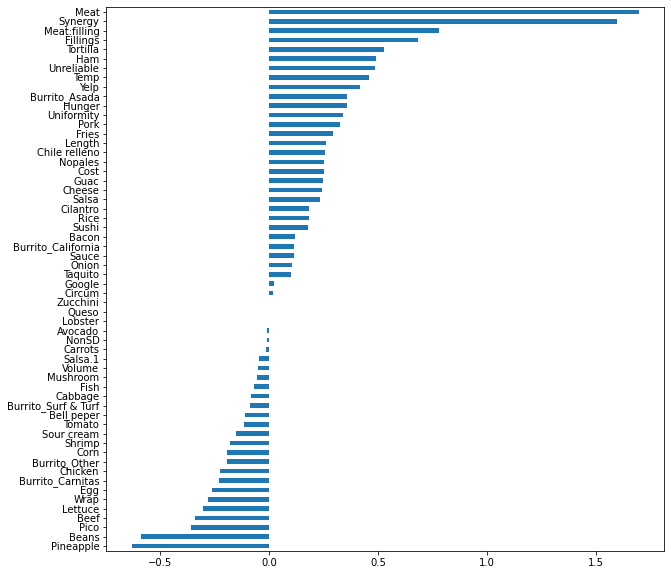

In [1380]:
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(10,10))
coefficients.sort_values().plot.barh();